In [ ]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import keras 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler

# Carga de datos

In [ ]:
drive.mount('/content/drive/')

miDatasetPath = '/content/bitcoin.csv'
df  = pd.read_csv(miDatasetPath, header=0)

df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date

df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31


In [ ]:
# vamos a agrupar los datos por dia


grupo = df.groupby('date')
precio = grupo['Weighted_Price'].mean()


precio=precio.dropna()

print(precio.shape,"\n")
print(precio[:5])
print(precio.tail())

(112,) 

date
2011-12-31    4.471603
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.208159
Name: Weighted_Price, dtype: float64
date
2012-04-16    4.960476
2012-04-17    4.986875
2012-04-18    5.094582
2012-04-19    5.127227
2012-04-20    5.136000
Name: Weighted_Price, dtype: float64


#Grafico de Historico de precios

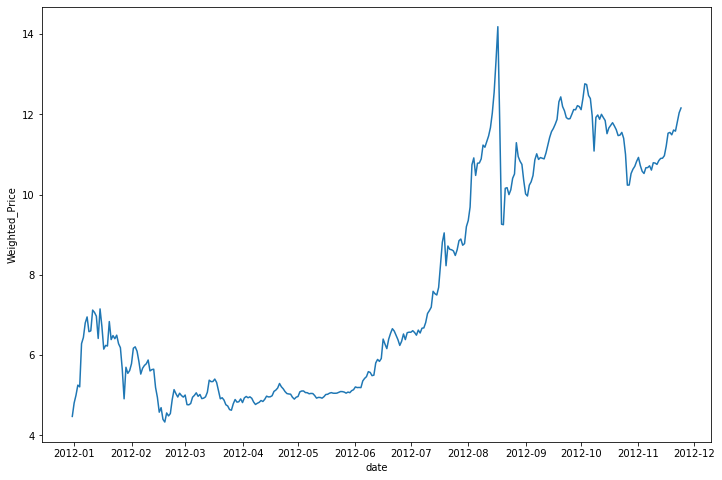

In [ ]:

fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(data=precio,ax=ax)

# Creacion de los Modelos RNN

In [ ]:
train_df = precio.iloc[0: -30]
test_df = precio.iloc[-30:]
print("Train Shape",train_df.shape)
print("Test Shape",test_df.shape)

Train Shape (300,)
Test Shape (30,)


In [ ]:

#Scale Trainning Data
training_values = train_df.values
training_values = np.reshape(training_values, (len(training_values), 1))

scaler = MinMaxScaler()
training_values = scaler.fit_transform(training_values)
x_train = training_values[0: len(training_values)-1]
y_train = training_values[1: len(training_values)]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

In [ ]:
x_train.shape

(299, 1, 1)

In [ ]:
#Scale Test Data
test_values = test_df.values
test_values = np.reshape(test_values, (len(test_values), 1))

scaler = MinMaxScaler()
test_values = scaler.fit_transform(test_values)
x_test = test_values[0: len(test_values)-1]
y_test = test_values[1: len(test_values)]
x_test = np.reshape(x_test, (len(x_test), 1, 1))

In [ ]:
x_test.shape

(29, 1, 1)

## Modelo 1: 2 capas LSTM 

In [ ]:
 
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
 
epocs = 30
model.compile(loss='mse', optimizer="adam", metrics=['mse'])
history = model.fit(x_train, y_train, epochs=epocs, verbose=1,  validation_data=(x_test, y_test))

Epoch 1/30
10/10 [==============================] - 4s 91ms/step - loss: 0.1491 - mse: 0.1491 - val_loss: 0.2012 - val_mse: 0.2012
Epoch 2/30
10/10 [==============================] - 0s 7ms/step - loss: 0.1314 - mse: 0.1314 - val_loss: 0.1785 - val_mse: 0.1785
Epoch 3/30
10/10 [==============================] - 0s 6ms/step - loss: 0.1386 - mse: 0.1386 - val_loss: 0.1550 - val_mse: 0.1550
Epoch 4/30
10/10 [==============================] - 0s 6ms/step - loss: 0.1140 - mse: 0.1140 - val_loss: 0.1313 - val_mse: 0.1313
Epoch 5/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0928 - mse: 0.0928 - val_loss: 0.1068 - val_mse: 0.1068
Epoch 6/30
10/10 [==============================] - 0s 7ms/step - loss: 0.0836 - mse: 0.0836 - val_loss: 0.0828 - val_mse: 0.0828
Epoch 7/30
10/10 [==============================] - 0s 7ms/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.0633 - val_mse: 0.0633
Epoch 8/30
10/10 [==============================] - 0s 7ms/step - loss: 0.0547 - mse: 0.0

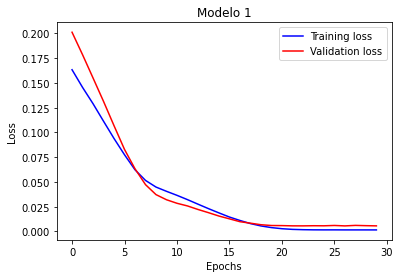

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Modelo 1")

## Modelo 2: 1 capa LSTM con dropout

In [ ]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

epocs = 30
model2.compile(loss='mse', optimizer="adam", metrics=['mse'])
history = model2.fit(x_train, y_train, epochs=epocs, verbose=1,  validation_data=(x_test, y_test))

Epoch 1/30
10/10 [==============================] - 2s 57ms/step - loss: 0.1324 - mse: 0.1324 - val_loss: 0.1767 - val_mse: 0.1767
Epoch 2/30
10/10 [==============================] - 0s 6ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1526 - val_mse: 0.1526
Epoch 3/30
10/10 [==============================] - 0s 6ms/step - loss: 0.1208 - mse: 0.1208 - val_loss: 0.1311 - val_mse: 0.1311
Epoch 4/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0993 - mse: 0.0993 - val_loss: 0.1127 - val_mse: 0.1127
Epoch 5/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0925 - mse: 0.0925 - val_loss: 0.0958 - val_mse: 0.0958
Epoch 6/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0631 - mse: 0.0631 - val_loss: 0.0819 - val_mse: 0.0819
Epoch 7/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0696 - val_mse: 0.0696
Epoch 8/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0552 - mse: 0.0

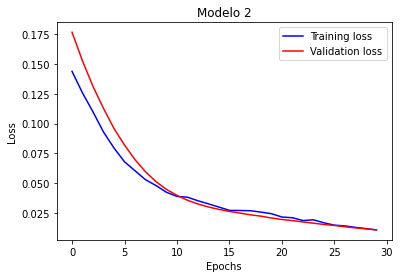

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Modelo 2")

El modelo 1 en la ultima epoca obtiene mejores metricas que el modelo2

**Modelo 1**

mse: 0.0014 - val_loss: 0.0057 - val_mse: 0.0057

**Modelo 2**

mse: 0.0109 - val_loss: 0.0107 - val_mse: 0.0107


Se utlizara le modelo 1 para hacer las predicciones

**Predecir valores los ultimos 10 valores**

In [ ]:
test_df = precio.iloc[-10:]

test_values = test_df.values
test_values = np.reshape(test_values, (len(test_values), 1))

scaler = MinMaxScaler()
test_values = scaler.fit_transform(test_values)
x_test = test_values[0: len(test_values)-1]
y_test = test_values[1: len(test_values)]
x_test = np.reshape(x_test, (len(x_test), 1, 1))

In [ ]:
result = model.predict(x_test)
result = np.reshape(result, (len(result), 1))
result = scaler.inverse_transform(result)
print("Prediccion")
print(result)

Prediccion
[[11.013183]
 [11.192776]
 [11.495293]
 [11.514748]
 [11.453249]
 [11.58    ]
 [11.548934]
 [11.815278]
 [12.096011]]


In [ ]:
y_true = scaler.inverse_transform(y_test)
print("Valores Reales")
print(y_true)

Valores Reales
[[11.20691065]
 [11.52803445]
 [11.54652263]
 [11.48737324]
 [11.60716906]
 [11.57854793]
 [11.81201521]
 [12.03793127]
 [12.15608853]]


In [ ]:
from sklearn.metrics import r2_score

score = r2_score(y_true,result)
score

0.5640802916458423

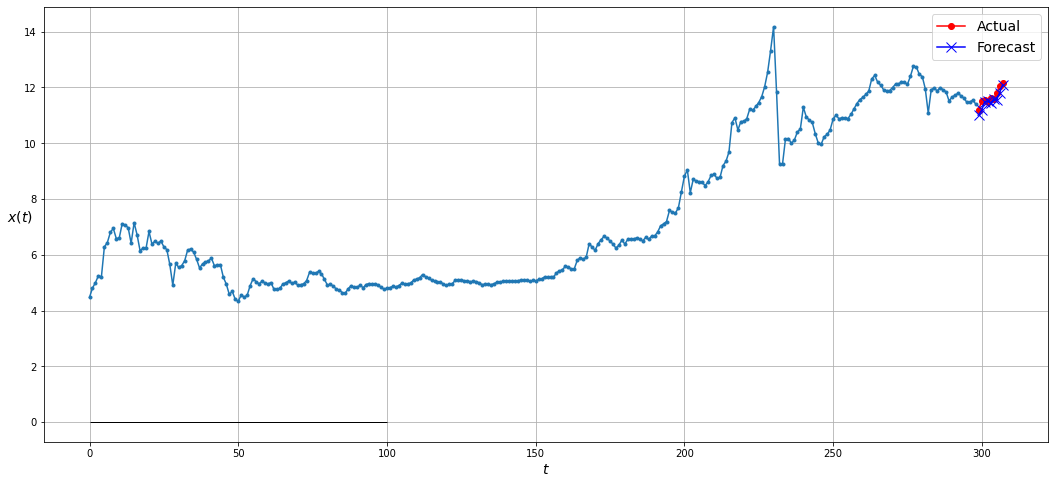

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=14)
    if y_label:
        plt.ylabel(y_label, fontsize=14, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
   
   # plt.axis([0, n_steps + 1, -1, 1])
    
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps =  X.shape[0]
    ahead = Y.shape[0]

    plot_series(X[:, 0, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[:, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[:, 0], "bx-", label="Forecast", markersize=10)
    #plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    

training_values = train_df.values
training_values = np.reshape(training_values, (len(training_values), 1))
x_train = training_values[0: len(training_values)-1]
x_train = np.reshape(x_train, (len(x_train), 1, 1))

plt.figure(figsize=(18,8))

plot_multiple_forecasts(x_train, y_true, result)

plt.show()


**Valores reales vs prediccion**

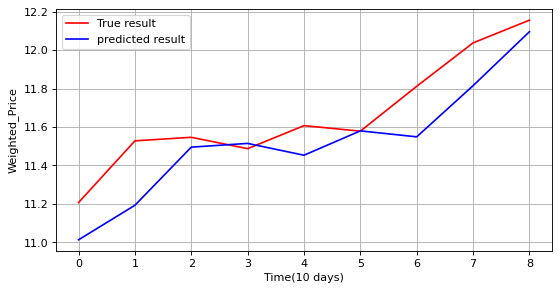

In [ ]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(y_true,color="r",label="True result")
plt.plot(result,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(10 days)")
plt.ylabel("Weighted_Price")
plt.grid(True)
plt.show()

# Predecir precios futuros

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
import plotly.express as px

Este experimento se hace sin agrupas fechas

In [ ]:
data = df[["date","Weighted_Price"]]
data=data.dropna()
data["date"].max()

datetime.date(2012, 9, 13)

In [ ]:
data.shape

(13225, 2)

In [ ]:

fig = px.line(data, x='date', y="Weighted_Price")
fig.show()

## Preprocesamiento de datos

In [ ]:

scaler = MinMaxScaler()

price_data = data['Weighted_Price'].values

price_data = price_data.reshape((-1,1))

# scale the data
price_data = scaler.fit_transform(price_data)

split_percent = 0.80
split = int(split_percent*len(price_data))

price_train = price_data[:split]
price_test = price_data[split:]

date_train = data['date'][:split]
date_test = data['date'][split:]

print(len(price_train))
print(len(price_test))

10580
2645


In [ ]:
look_back = 30

train_generator = TimeseriesGenerator(price_train, price_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(price_test, price_test, length=look_back, batch_size=1)

In [ ]:

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[look_back, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])


model.compile(optimizer='adam', loss='mse')
num_epochs = 50
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/50
528/528 [==============================] - 14s 21ms/step - loss: 0.0199
Epoch 2/50
528/528 [==============================] - 11s 20ms/step - loss: 0.0025
Epoch 3/50
528/528 [==============================] - 11s 20ms/step - loss: 0.0013
Epoch 4/50
528/528 [==============================] - 11s 20ms/step - loss: 7.8982e-04
Epoch 5/50
528/528 [==============================] - 11s 20ms/step - loss: 6.0641e-04
Epoch 6/50
528/528 [==============================] - 11s 20ms/step - loss: 4.9248e-04
Epoch 7/50
528/528 [==============================] - 11s 20ms/step - loss: 6.2532e-04
Epoch 8/50
528/528 [==============================] - 11s 21ms/step - loss: 4.3746e-04
Epoch 9/50
528/528 [==============================] - 11s 21ms/step - loss: 4.9216e-04
Epoch 10/50
528/528 [==============================] - 11s 21ms/step - loss: 4.2251e-04
Epoch 11/50
528/528 [==============================] - 11s 21ms/step - loss: 3.5598e-04
Epoch 12/50
528/528 [==============================] 

## Validar el test set contra la prediccion

In [ ]:
prediction = model.predict_generator(test_generator)

In [ ]:
import plotly.graph_objects as go


train =price_train.reshape(-1, 1)
test =price_test.reshape(-1, 1)
pred =prediction.reshape(-1, 1)

train= scaler.inverse_transform(train)
test= scaler.inverse_transform(test)
pred= scaler.inverse_transform(pred)

train = train.reshape((-1))
test = test.reshape((-1))
pred = pred.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = pred,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "BitCoin prices",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

## Prediccion del siguiente mes: 2012-12

In [ ]:
look_back=3000

price_data = price_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = price_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = data['date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [ ]:

forecast =forecast.reshape(-1, 1)
forecast= scaler.inverse_transform(forecast)
forecast = forecast.reshape((-1))
forecast

array([11.27      ,  9.66641205,  9.66641205,  9.37192226,  9.66641205,
        9.561224  ,  9.60329847,  9.50863222,  9.60329847,  9.50863222,
        9.50863222,  9.52966795,  9.52966795,  9.52966795,  9.52966795,
        9.50863222,  9.37192226,  9.35090302,  9.32685066,  9.1974512 ,
        9.19324885,  8.93592335,  8.92204207,  8.8679581 ,  8.83652735,
        8.83652735,  9.2547851 ,  9.561224  ,  9.5102073 ,  9.49285551,
        9.51915027])

In [ ]:

historical_price =price_data.reshape(-1, 1)
historical_price= scaler.inverse_transform(historical_price)
historical_price = historical_price.reshape((-1))

In [ ]:

date_train = data['date']

trace1 = go.Scatter(
    x = date_train,
    y = historical_price,
    mode = 'lines',
    name = 'Datos Reales'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediccion'
)

layout = go.Layout(
    title = "BitCoin prices",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()